# Cognition & Computation Project
#### BY FELICE FRANCARIO
ID: 2097475,
Date=06/02/2024


The goal of this project is to implement simulations to explore computational models of visual concept leanrning through multi-class classification of images using the different representations layers learned by training a Deep Belief Network on an image Dataset. A Deep Belief Network (DBN) is a type of neural network model comprising multiple layers that employs a generative approach to unsupervised learning, where layers capture increasingly abstract representations of data.


In [ ]:
def get_dbn_library():
  files = ["DBN.py", "RBM.py"]
  repository_url = "https://raw.githubusercontent.com/flavio2018/Deep-Belief-Network-pytorch/master/"
  for file in files:
    ! wget -O {file} {repository_url}{file}

In [ ]:
%%capture
get_dbn_library()

In [ ]:
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as functional
import torchvision as tv
from tqdm.notebook import tqdm
import math

from DBN import DBN

import scipy.cluster as cluster
import sklearn.preprocessing

import gzip
import numpy as np
from sklearn.metrics import confusion_matrix
import pandas as pd
from torchvision.transforms import ToPILImage


## EMNIST dataset
For the project i decided to use the EMNIST dataset, in particular the EMNIST LETTERS Dataset which consists of 145600 characters balanced in 26 different classes corresponding to the english alphabet letters.

In [ ]:
print(torch.cuda.is_available())
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

True


In [ ]:
%%capture

emnist_train=tv.datasets.EMNIST("data/",
                                split="letters",
                                train=True,
                                download=True,
                                transform=tv.transforms.Compose(
                                        [tv.transforms.ToTensor()]
                                ))


emnist_test = tv.datasets.EMNIST("data/",
                                 split="letters",
                                train=False,
                                download=True,
                                transform=tv.transforms.Compose(
                                        [tv.transforms.ToTensor()]
                                ))

Normalization: In the following cell we normalize the original output of integer values between [0,255] to a float between [0,1].

In [ ]:
emnist_train.data = (emnist_train.data.type(torch.FloatTensor)/255)
emnist_test.data = (emnist_test.data.type(torch.FloatTensor)/255)

In [ ]:
emnist_train.data = emnist_train.data.to(device)
emnist_test.data = emnist_test.data.to(device)
emnist_train.targets = emnist_train.targets.to(device)
emnist_test.targets = emnist_test.targets.to(device)

In [ ]:
len(emnist_train.data)

124800

In [ ]:
len(emnist_test.data)

20800

The training and test set were obtained directly from torchvision.datasets, where the training set consists of 124800 examples while the test set consists of 20800 examples. The percentage split of the total data is about 86% to 14% respectively.

## Model training

Here i build a Deep Belief Network with 3 hidden layers of 400 , 700 and 900 units respectively. Then i apply a readout classfier on each of the 3 layers and compute the accuracy of classification on a test set. The layer sizes was chosen by seeing the results of different combinations visual recptive fields and accuracies.

Here is a list of some of different sizes tried for the hidden layers:

- With 500,600,800: I notice that the accuracy of the second layer is slightly inferior to the accuracy of the first layer and the visual receptive layer is less complex.

- with 500,500,500 The accuracy in the first 1st and 3rd layer is the same around 72% and 73% while the second layer decreases by 2% to 70%.

- With 400,500,800 the accuracy of the layers is 71%,70%,73% respectively.

- with 400,400,400 the accuracy decreases in all layers to 71%,69%,71%.

- with 400,700,900 the accuracy gradually increases from 71.2% to 71.3% to 73.2% respectively.
- with 600,500,400 the accuracy of the layers is 72%,70%,72% respectively.

- With 600,800,800 i get 72%,71%,74% respectively.

- With 600,800,1000 i get the same.

- with 600,1000,800 i get 72.5%, 71.8%, 73.7% respectively.
- with 500,1200,1000 i get 72%,71.8%,73.6% respectively.
- with 700,500,400 i get 73%, 70%,72.7% respectively.

I kept the momentum and learning rate values the same that worked well for a DBN trained on the MNIST digits dataset and set the number of Contrastive Divergence steps equal to 1 to have faster training.







### DBN

In [ ]:
dbn_emnist = DBN(visible_units=28*28,
                hidden_units=[400, 700, 900],
                k=1,
                learning_rate=0.1,
                learning_rate_decay=False,
                initial_momentum=0.5,
                final_momentum=0.95,
                weight_decay=0.0001,
                xavier_init=False,
                increase_to_cd_k=False,
                use_gpu=torch.cuda.is_available())

In [ ]:
num_epochs = 50
batch_size = 100

dbn_emnist.train_static(
    emnist_train.data,
    emnist_train.targets,
    num_epochs,
    batch_size
)

--------------------
Training RBM layer 1
|Epoch |avg_rec_err |std_rec_err  |mean_grad |std_grad  |
|10    |1.1132     |0.0413       |361.7462   |6.2010     |
|20    |1.0718     |0.0376       |346.8325   |5.0639     |
|30    |1.0651     |0.0395       |344.3212   |5.5840     |
|40    |1.0565     |0.0387       |339.7930   |5.0425     |
|50    |1.0544     |0.0382       |337.7402   |4.8298     |
--------------------
Training RBM layer 2
|Epoch |avg_rec_err |std_rec_err  |mean_grad |std_grad  |
|10    |1.2189     |0.0370       |255.0997   |3.3186     |
|20    |1.1829     |0.0349       |251.2922   |3.1899     |
|30    |1.1763     |0.0360       |250.7353   |3.0945     |
|40    |1.1743     |0.0361       |250.5430   |3.0678     |
|50    |1.1709     |0.0364       |249.7069   |3.1609     |
--------------------
Training RBM layer 3
|Epoch |avg_rec_err |std_rec_err  |mean_grad |std_grad  |
|10    |0.6173     |0.0206       |286.4168   |3.6340     |
|20    |0.5885     |0.0191       |284.3389   |3.854

##Visual Receptive Fields

In this section we will visualize the visual receptive fields of the weights of the 3 layers projected to 28x28 images

In [ ]:
def get_weights(dbn, layer):
  return dbn.rbm_layers[layer].W.cpu().numpy()

def apply_threshold(weights, threshold=0):
  return weights * (abs(weights) > threshold)

def apply_min_max_scaler(learned_weights):
  original_shape = learned_weights.shape
  min_max_scaler = sklearn.preprocessing.MinMaxScaler()
  min_max_scaled_learned_weights = min_max_scaler.fit_transform(learned_weights.ravel().reshape(-1,1))
  min_max_scaled_learned_weights = min_max_scaled_learned_weights.reshape(original_shape)
  return min_max_scaled_learned_weights

def plot_layer_receptive_fields(weights):
  num_subplots = 100
  n_rows_cols = int(math.sqrt(num_subplots))
  fig, axes = plt.subplots(n_rows_cols, n_rows_cols, sharex=True, sharey=True, figsize=(10, 10))
  for i in range(num_subplots):
    row = i % n_rows_cols
    col = i // n_rows_cols
    axes[row, col].imshow(weights[i,:].reshape((28,28)), cmap=plt.cm.gray)

###1st hidden layer weights

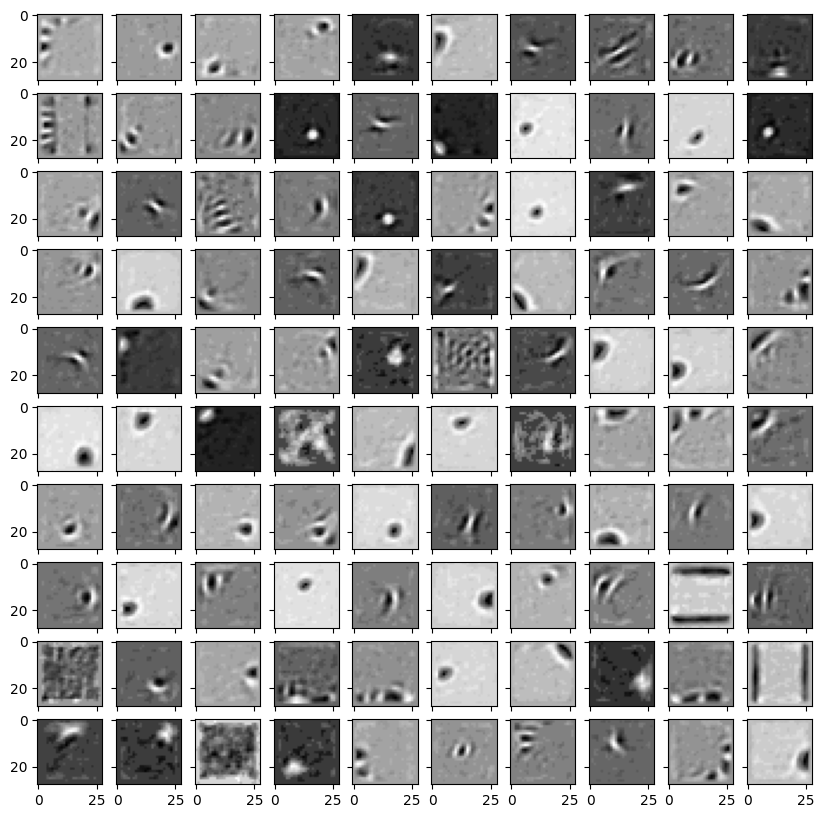

In [ ]:
w1 = get_weights(dbn_emnist, layer=0)
w1 = apply_threshold(w1, 0.1)
w1 = apply_min_max_scaler(w1)

plot_layer_receptive_fields(w1.T)

###2nd Hidden Layer projected weights

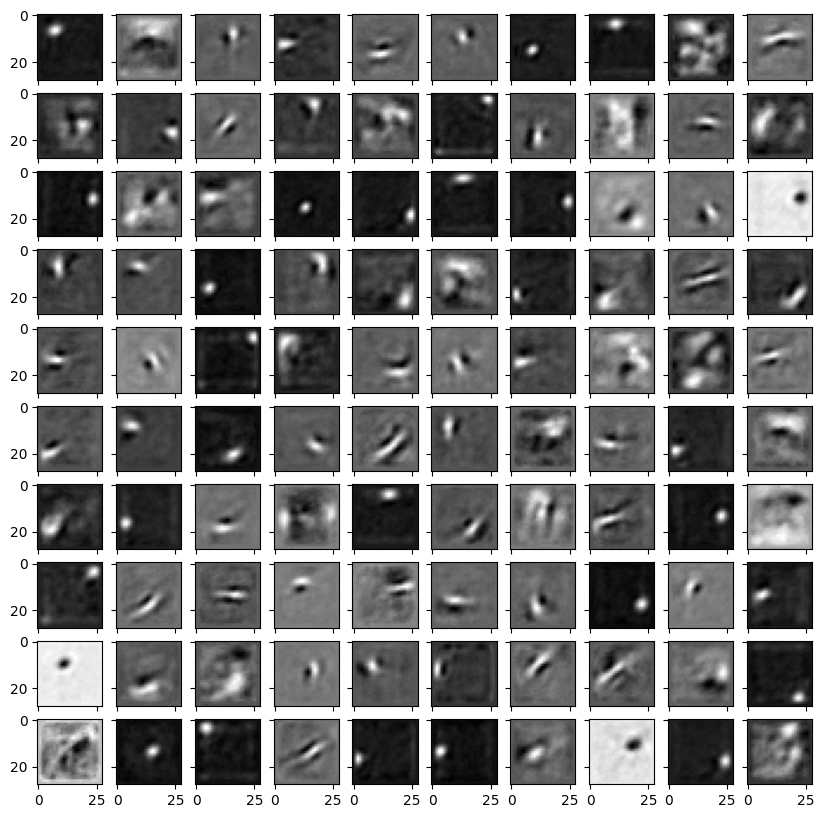

In [ ]:
w1 = get_weights(dbn_emnist, layer=0)
w2 = get_weights(dbn_emnist, layer=1)

w1 = apply_threshold(w1, 0.1)
w2 = apply_threshold(w2, 0.1)

w_product = (w1 @ w2)  # here we do the projection
w_product = apply_threshold(w_product, 0.1)
w_product = apply_min_max_scaler(w_product)

plot_layer_receptive_fields(w_product.T)

###3rd layer projected weights

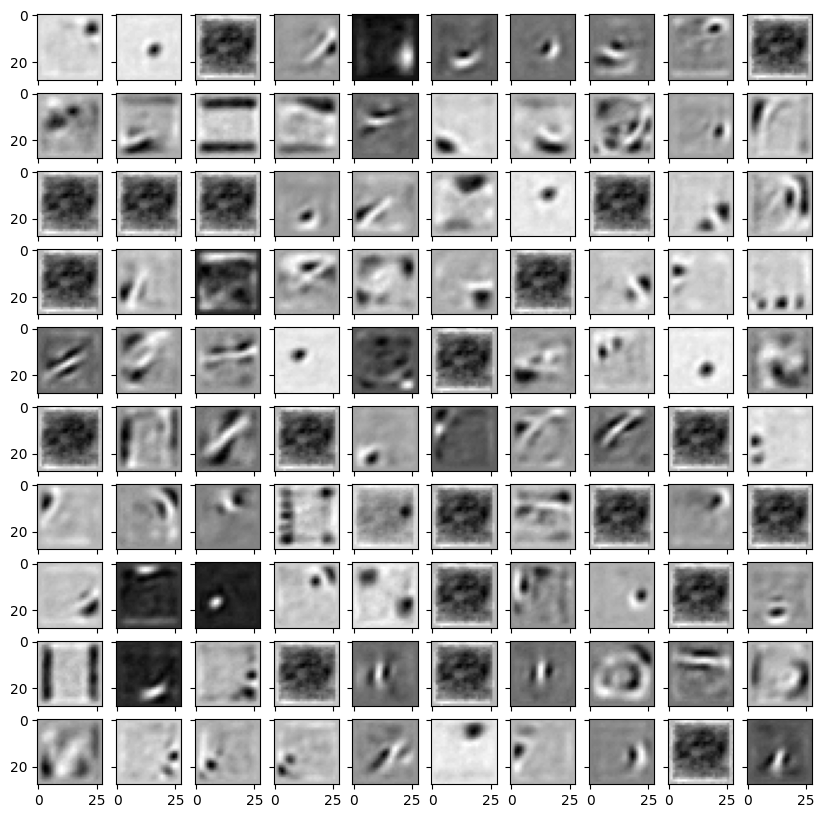

In [ ]:
w1 = get_weights(dbn_emnist, layer=0)
w2 = get_weights(dbn_emnist, layer=1)
w3 = get_weights(dbn_emnist, layer=2)

w1 = apply_threshold(w1, 0.1)
w2 = apply_threshold(w2, 0.1)
w3 = apply_threshold(w3, 0.1)

w_product_12 = (w1 @ w2)  # here we do the projection
w_product_23 = (w_product_12 @ w3)  # here we do the projection
w_product_23 = apply_threshold(w_product_23, 0.1)
w_product_23 = apply_min_max_scaler(w_product_23)

plot_layer_receptive_fields(w_product_23.T)

From the visual receptive fields we can see that the deeper the layer the more complex structures of letters are captured. This is similar to the hierarchical organization observed analyzing the spikes of the neurons in a human brain , that respond to increasingly more complex visual stimuli including shapes, colors, motion, orientation and even faces.

### Readout classifiers

In [ ]:
def get_kth_layer_repr(input, k, device):
  flattened_input = input.view((input.shape[0], -1)).type(torch.FloatTensor).to(device)
  hidden_repr, __ = dbn_emnist.rbm_layers[k].to_hidden(flattened_input)
  return hidden_repr

In [ ]:
hidden_repr_layer_1 = get_kth_layer_repr(emnist_train.data, 0, device)
hidden_repr_layer_2 = get_kth_layer_repr(hidden_repr_layer_1, 1, device)
hidden_repr_layer_3 = get_kth_layer_repr(hidden_repr_layer_2, 2, device)

In [ ]:
class LinearModel(torch.nn.Module):
  def __init__(self, rbm_layer_size):
    super().__init__()
    self.linear = torch.nn.Linear(rbm_layer_size, 26)

  def forward(self, x):
    return self.linear(x)

In [ ]:
layer_size = dbn_emnist.rbm_layers[0].W.shape[1]
linear_1 = LinearModel(layer_size).to(device)

layer_size = dbn_emnist.rbm_layers[1].W.shape[1]
linear_2 = LinearModel(layer_size).to(device)

layer_size = dbn_emnist.rbm_layers[2].W.shape[1]
linear_3 = LinearModel(layer_size).to(device)

In [ ]:
def train(network, input, epochs=1000):
  optimizer = torch.optim.SGD(network.parameters(), lr=0.05)
  loss_fn = torch.nn.CrossEntropyLoss()

  for epoch in range(epochs):
    optimizer.zero_grad()
    predictions = network(input).squeeze()
    targets = emnist_train.targets.reshape(predictions.shape[0])  # here are the labels
    loss = loss_fn(predictions, targets-1)
    loss.backward()
    optimizer.step()

    if epoch % 100 == 0:
      print("epoch : {:3d}/{}, loss = {:.4f}".format(epoch + 1, epochs, loss))

In [ ]:
train(linear_1, hidden_repr_layer_1)
train(linear_2, hidden_repr_layer_2)
train(linear_3, hidden_repr_layer_3)

epoch :   1/1000, loss = 3.2824
epoch : 101/1000, loss = 2.2691
epoch : 201/1000, loss = 1.7936
epoch : 301/1000, loss = 1.5467
epoch : 401/1000, loss = 1.3999
epoch : 501/1000, loss = 1.3020
epoch : 601/1000, loss = 1.2309
epoch : 701/1000, loss = 1.1761
epoch : 801/1000, loss = 1.1321
epoch : 901/1000, loss = 1.0955
epoch :   1/1000, loss = 3.2807
epoch : 101/1000, loss = 2.1884
epoch : 201/1000, loss = 1.7226
epoch : 301/1000, loss = 1.4922
epoch : 401/1000, loss = 1.3566
epoch : 501/1000, loss = 1.2654
epoch : 601/1000, loss = 1.1986
epoch : 701/1000, loss = 1.1465
epoch : 801/1000, loss = 1.1042
epoch : 901/1000, loss = 1.0688
epoch :   1/1000, loss = 3.2574
epoch : 101/1000, loss = 2.1930
epoch : 201/1000, loss = 1.7139
epoch : 301/1000, loss = 1.4725
epoch : 401/1000, loss = 1.3304
epoch : 501/1000, loss = 1.2356
epoch : 601/1000, loss = 1.1665
epoch : 701/1000, loss = 1.1131
epoch : 801/1000, loss = 1.0700
epoch : 901/1000, loss = 1.0340


In [ ]:
hidden_repr_layer_1_test = get_kth_layer_repr(emnist_test.data, 0, device)
hidden_repr_layer_2_test = get_kth_layer_repr(hidden_repr_layer_1_test, 1, device)
hidden_repr_layer_3_test = get_kth_layer_repr(hidden_repr_layer_2_test, 2, device)

In [ ]:
predictions_test1 = linear_1(hidden_repr_layer_1_test)
predictions_test2 = linear_2(hidden_repr_layer_2_test)
predictions_test3 = linear_3(hidden_repr_layer_3_test)

In [ ]:
def compute_accuracy(predictions_test, targets):
  predictions_indices = predictions_test.max(axis=1).indices  # convert probabilities to indices
  accuracy = (predictions_indices == (targets-1)).sum() / len(targets)
  return accuracy.item()

###Linear Readout classification from first Hidden layer

In [ ]:
compute_accuracy(predictions_test1, emnist_test.targets)

0.7163461446762085

###Linear Readout classification from second Hidden layer

In [ ]:
compute_accuracy(predictions_test2, emnist_test.targets)

0.7183173298835754

###Linear Readout classification from third Hidden layer

In [ ]:
compute_accuracy(predictions_test3, emnist_test.targets)

0.7327404022216797

###Classification Matrix from third(Final) Layer

The true labels are integer numbers from 1 to 26 while the predictions are obtained from the indices which fo from 0 to 25 . So to make them coincide in the confusion matrix added 1 to the prediction values. I then associated each integer value to its corresponding capital letter.

In [ ]:
true_labels_cpu = emnist_test.targets.cpu().numpy()
predictions_cpu = (predictions_test3.max(dim=1).indices + 1).cpu().numpy()
conf_matrix = confusion_matrix(true_labels_cpu, predictions_cpu)

letters=["A","B","C","D","E","F","G","H","I","J","K","L","M","N","O","P","Q","R","S","T","U","V","W","X","Y","Z"]
conf_matrix_df = pd.DataFrame(conf_matrix, index=letters, columns=letters)

# Print the formatted confusion matrix
print("Confusion Matrix:")
print(conf_matrix_df)

Confusion Matrix:
     A    B    C    D    E    F    G    H    I    J  ...    Q    R    S    T  \
A  479    4   10   25   13    6   19   42    1    1  ...   32    0    5    0   
B   10  611    0   18   23    0   26   24   12    4  ...    3    1    6    2   
C    9    0  659    3   46    3    8    0    2    2  ...    2   11    1    3   
D   14   50    6  525    3    0    4    4    3   18  ...    5    0    0    1   
E   23   11   61    1  628   13    7    0    0    2  ...    6   11    8    3   
F    2    0    2    3    1  580    2    1   10    5  ...   16   29    0   53   
G   38   28   23   11   13   11  412    1    2   29  ...  136    3   42    6   
H   16    4    1   18    0    5    1  550   13    3  ...    0    4    0    0   
I    0    1    0    1    1    1    0    1  496   37  ...    0    3    5    5   
J    1    1    0   41    1    5    3    0    9  608  ...    4    0   20   49   
K   10    9   13    3    1    3    0   55    7    3  ...    0    7    0    6   
L    2    4   27    6 

##Internal representations (Hierarchical clustering)

In [ ]:
def get_mask(label):
  labels = emnist_train.targets.cpu().numpy()
  return labels == label

def get_label_to_mean_hidd_repr(hidden_representation):
  hidden_representation_np = hidden_representation.cpu().numpy()
  return {
    letters[i]: hidden_representation_np[get_mask(i+1)].mean(axis=0)  # here we filter by class and compute the mean
    for i in range(0,26)
  }

def get_hidden_reprs_matrix(hidden_representation):  # we use this to build the matrices
  label_to_mean_hidd_repr = get_label_to_mean_hidd_repr(hidden_representation)
  return np.concatenate(
    [np.expand_dims(label_to_mean_hidd_repr[letters[i]], axis=0)  # here we adjust the shape of centroids to do the concat
    for i in range(0,26)])

In [ ]:
mean_hidd_repr_matrix_1 = get_hidden_reprs_matrix(hidden_repr_layer_1)
mean_hidd_repr_matrix_2 = get_hidden_reprs_matrix(hidden_repr_layer_2)
mean_hidd_repr_matrix_3 = get_hidden_reprs_matrix(hidden_repr_layer_3)

In [ ]:
def plot_dendrogram(mean_repr_matrix, title=""):
  fig, ax = plt.subplots()
  linkage = cluster.hierarchy.linkage(mean_repr_matrix, method="complete")  # we run the clustering algorithm here
  dendrogram = cluster.hierarchy.dendrogram(linkage,labels=letters)
  ax.set_title(title)

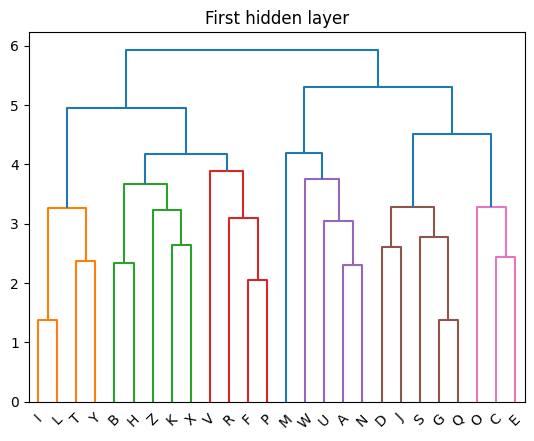

In [ ]:
plot_dendrogram(mean_hidd_repr_matrix_1, "First hidden layer")

Here you can already see similar shaped letters are closer to each other in the clusters based just on the weights of first hidden representation. An example is F and P have similar shape consequently are the closest based on the mean of the first hidden layer outputs. The next closest is R  which visually is similar to P (just 1 more line) .

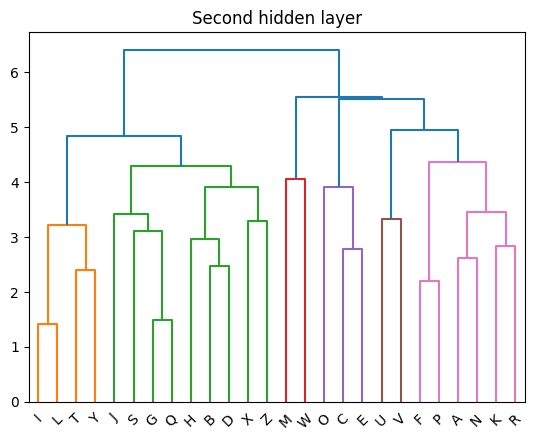

In [ ]:
plot_dendrogram(mean_hidd_repr_matrix_2, "Second hidden layer")

As you can notice the distances between classes changes as for example B is closest to D in this case while based on the previous layer output B was closest to H and D was closest to J. This seems to capture better the more similar letter clusters

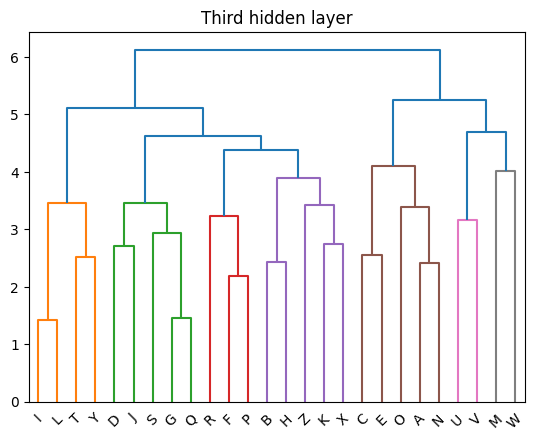

In [ ]:
plot_dendrogram(mean_hidd_repr_matrix_3, "Third hidden layer")

#Adding Noise

### Psychometric curves

In the following code output you can see the effect of adding random noise to the image input on the accuracy based on the number of layers of the Deep Belief Network.


In [ ]:
def inject_noise(emnist_data, noise_level):
  random_gaussian_tensor = torch.randn(emnist_data.shape, device = device)*noise_level
  return emnist_data + random_gaussian_tensor

In [ ]:
def get_accuracy_values_at_noise_level(noise_level):

  emnist_test_with_noise = inject_noise(emnist_test.data, noise_level)  # first, let's create noisy test images

  hidden_repr_layer_1_noisy = get_kth_layer_repr(emnist_test_with_noise, 0, device)  # here we compute the DBN representations
  hidden_repr_layer_2_noisy = get_kth_layer_repr(hidden_repr_layer_1_noisy, 1, device)
  hidden_repr_layer_3_noisy = get_kth_layer_repr(hidden_repr_layer_2_noisy, 2, device)

  predictions_first_hidden_noisy = linear_1(hidden_repr_layer_1_noisy)  # here we use the previously-trained read-out classifiers
  predictions_second_hidden_noisy = linear_2(hidden_repr_layer_2_noisy)
  predictions_third_hidden_noisy = linear_3(hidden_repr_layer_3_noisy)

  accuracy_first_hidden = compute_accuracy(predictions_first_hidden_noisy, emnist_test.targets)
  accuracy_second_hidden = compute_accuracy(predictions_second_hidden_noisy, emnist_test.targets)
  accuracy_third_hidden = compute_accuracy(predictions_third_hidden_noisy, emnist_test.targets)


  return accuracy_first_hidden, accuracy_second_hidden, accuracy_third_hidden

In [ ]:
def plot_noise_robustness_curves(noise_levels):
  accuracy_values_first_hidden = []
  accuracy_values_second_hidden = []
  accuracy_values_third_hidden = []


  for noise_level in noise_levels:
    acc = get_accuracy_values_at_noise_level(noise_level)
    accuracy_values_first_hidden.append(acc[0])
    accuracy_values_second_hidden.append(acc[1])
    accuracy_values_third_hidden.append(acc[2])


  fig, ax = plt.subplots()
  ax.plot(range(len(noise_levels)), accuracy_values_first_hidden)
  ax.plot(range(len(noise_levels)), accuracy_values_second_hidden)
  ax.plot(range(len(noise_levels)), accuracy_values_third_hidden)


  ax.set_title("Robustness to noise")
  ax.set_xlabel("Noise level (%)")
  ax.set_ylabel("Accuracy")
  plt.xticks(range(len(noise_levels)), [int(l*100) for l in noise_levels])
  plt.legend(["First hidden", "Second hidden", "Third hidden"])

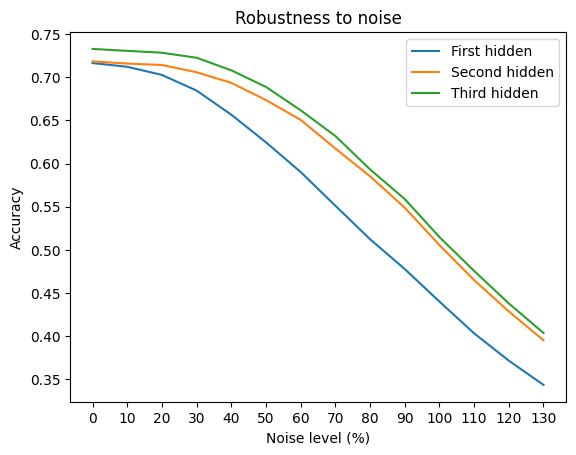

In [ ]:
noise_levels = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 1.1, 1.2, 1.3]
plot_noise_robustness_curves(noise_levels)

From the above plot we can clearly see that deeper layers are more resistent to noise

## Perturbing the DBN with adversarial attacks

### Fast gradient sign method


With the Fast gradient sign method technique, gradients of the loss function with respect to the input data are computed, and then the input data is adjusted in the direction that maximizes the loss.
We will see how the DBN's accuracy responds to varying degrees of adversarial attacks.


In [ ]:
def fgsm_attack(image, epsilon, data_grad):
    # Collect the element-wise sign of the data gradient
    sign_data_grad = data_grad.sign()

    # Create the perturbed image by adjusting each pixel of the input image
    perturbed_image = image + epsilon*sign_data_grad

    # Adding clipping to maintain [0,1] range
    perturbed_image = torch.clamp(perturbed_image, 0, 1)

    # Return the perturbed image
    return perturbed_image.to(image.device)

### Adversarial samples

In [ ]:
class DBNWithReadOut(torch.nn.Module):
    def __init__(self, dbn_emnist, readouts, readout_level=0):
        super().__init__()
        self.readouts = readouts
        self.dbn_emnist = dbn_emnist
        self._require_grad()
        self.readout_level = readout_level

    def _require_grad(self):
      for rbm in self.dbn_emnist.rbm_layers:
        rbm.W.requires_grad_()
        rbm.h_bias.requires_grad_()

    def forward(self, image):
      """This forward pass uses probabilities instead of samples as RBM outputs
       to backpropagate the gradient"""
      p_v = image
      hidden_states = []
      for rbm in self.dbn_emnist.rbm_layers:
        p_v = p_v.view((p_v.shape[0], -1))  # flatten
        p_v, v = rbm(p_v)
        hidden_states.append(p_v)
      return self.readouts[self.readout_level].forward(hidden_states[self.readout_level])

In [ ]:
dbn_with_readout = DBNWithReadOut(dbn_emnist, [linear_1, linear_2, linear_3], readout_level=2).to(device)

### Example of a random regular sample

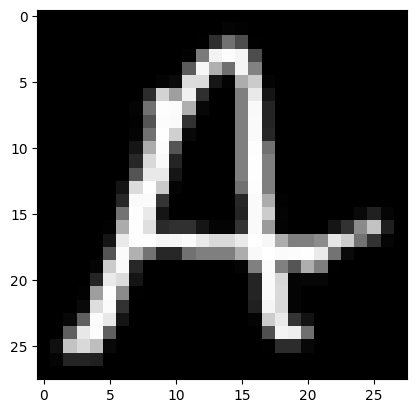

In [ ]:
test_sample_idx = 4
test_image = emnist_test.data[test_sample_idx].reshape(1,784)
test_image_transposed = torch.transpose(test_image.reshape(28,28).to('cpu'), 0, 1)  # Transpose the image
plt.imshow(test_image_transposed.squeeze(), cmap='gray')  # Squeeze the tensor to remove the batch dimension
plt.show()

In [ ]:
emnist_test.data.size()

torch.Size([20800, 28, 28])

In [ ]:
attacked_model = dbn_with_readout

In [ ]:
test_image.requires_grad_()
model_outputs = attacked_model(test_image)
prediction = torch.argmax(model_outputs)
print(f"The prediction of the model for this clean sample is {letters[prediction]}.")

The prediction of the model for this clean sample is A.


### Visualization of the corresponding adversarial sample.


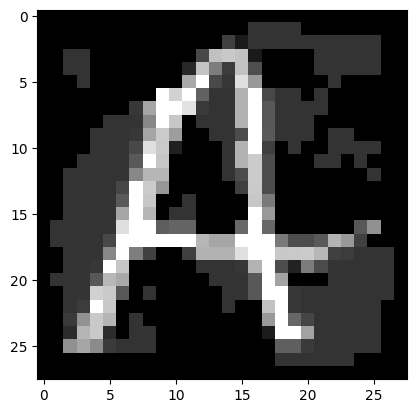

In [ ]:
epsilon = 0.2  # define strenght of the attack
test_image_label = emnist_test.targets[test_sample_idx].unsqueeze(0)  # get ground truth label for that image
loss_value = torch.nn.functional.cross_entropy(model_outputs, test_image_label)  # get loss value
attacked_model.zero_grad()
loss_value.backward()
image_grad = test_image.grad.data  # get the gradient of the pixels w.r.t. the loss
perturbed_image = fgsm_attack(test_image, epsilon, image_grad)

perturbed_image_np = perturbed_image.detach().to('cpu')#.numpy()
perturbed_image_np_tr=torch.transpose(perturbed_image_np.reshape(28,28),0,1)
__ = plt.imshow(perturbed_image_np_tr,cmap='gray')

In [ ]:
model_outputs = attacked_model(perturbed_image.view((perturbed_image.shape[0], -1)))
print(f"The prediction of the model for the perturbed sample is {letters[torch.argmax(model_outputs)]}.")

The prediction of the model for the perturbed sample is A.


### Resisting to adversarial attacks

In evaluating Deep Belief Networks (DBNs) for robustness against adversarial attacks, the incorporation of reconstruction of the input is a good solution for resistance to adversarial attacks

In [ ]:
def test_robustness_to_attack(model, dev, test_loader, epsilon, num_steps=0, verbose=True):
    correct = 0
    print_reconstruction = num_steps > 0
    model=model.to(dev)
    for data, target in tqdm(test_loader):
        data, target = data.to(dev), target.to(dev)
        #print("Shape of data tensor:", data.shape)
        #print("Shape of target tensor:", target.shape)
        data = data.reshape(-1, 784)
        data.requires_grad = True  # Important for Attack

        output = model.forward(data)

        init_pred = torch.argmax(output)

        if (print_reconstruction and verbose):
          print("\nHere's the original sample:\n")
          plt.imshow(np.transpose(data[0].detach().to('cpu').numpy().reshape(28,28)),cmap='gray')
          plt.show()

        loss = functional.nll_loss(output, target-1)
        model.to(dev)
        model.zero_grad()
        loss.backward()
        data_grad = data.grad.data  # collect the gradient of the input data
        perturbed_data = fgsm_attack(data, epsilon, data_grad)

        if (print_reconstruction and verbose):
            print("\nHere's a perturbed sample:\n")
            plt.imshow(np.transpose(perturbed_data[0].detach().to('cpu').numpy().reshape(28,28)),cmap='gray')
            plt.show()


        # If requested, reconstruct the input iterating forward-backward dynamics
        if num_steps > 0:
            for __ in range(0, num_steps):
                perturbed_data, __ = model.dbn_emnist.reconstruct(perturbed_data)
            if (print_reconstruction and verbose):
                print(f"\nHere's what a {num_steps}-steps reconstructed sample looks like:\n")
                plt.imshow(np.transpose(perturbed_data[0].detach().to('cpu').numpy().reshape(28,28)),cmap='gray')
                plt.show()
                print_reconstruction = False

        # Re-classify the perturbed image
        output = model(perturbed_data)#.to('cpu')
        target=target-1
        # Check for success
        # get the index of the max element in the output

        final_pred = output.max(1, keepdim=True)[1]
        final_pred = output.argmax(-1)
        correct += (final_pred == target).sum()

    # Calculate final accuracy for this epsilon
    final_acc = correct/float(len(test_loader.sampler))
    print("\nEpsilon: {}\nTest Accuracy: {:.2f}%\n".format(epsilon, final_acc*100))

    return final_acc.item()

In [ ]:
test_loader = torch.utils.data.DataLoader(
    tv.datasets.EMNIST("data/",split="letters",train=False,download=False,transform=tv.transforms.Compose([tv.transforms.ToTensor()])),
    batch_size=100, shuffle=True)

  0%|          | 0/208 [00:00<?, ?it/s]


Here's the original sample:



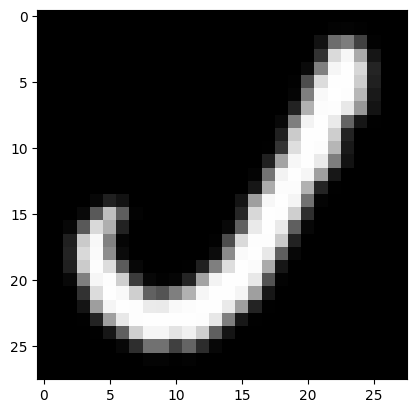


Here's a perturbed sample:



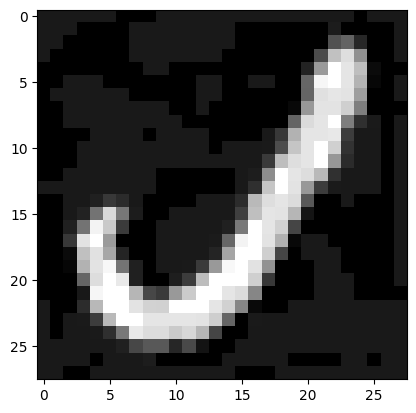


Here's what a 1-steps reconstructed sample looks like:



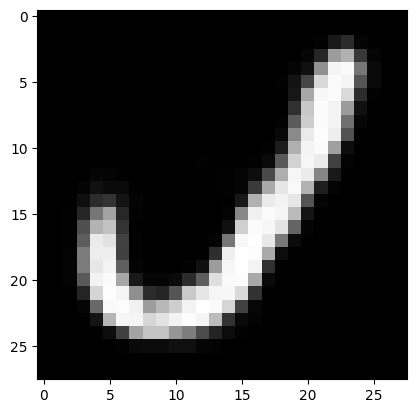


Epsilon: 0.1
Test Accuracy: 55.62%



In [ ]:
final_acc = test_robustness_to_attack(dbn_with_readout, device,
                                      test_loader, epsilon=0.1,
                                      num_steps=1)

### Effect of the noise parameter $\epsilon$

Let's compare the robustness of each model to adversarial attacks of different "strengths":

In [ ]:
epsilon_values = [0, 0.05, 0.10, 0.15, 0.20, 0.25]

def test_epsilon_values_effect(model, n_steps):
  accuracies = list()

  for eps in epsilon_values:
      acc = test_robustness_to_attack(model, device, test_loader, eps, num_steps=n_steps, verbose=False)
      accuracies.append(acc)

  return accuracies

In [ ]:
%%capture
accuracies_dbn_0 = test_epsilon_values_effect(dbn_with_readout, n_steps=0)
accuracies_dbn_1 = test_epsilon_values_effect(dbn_with_readout, n_steps=1)

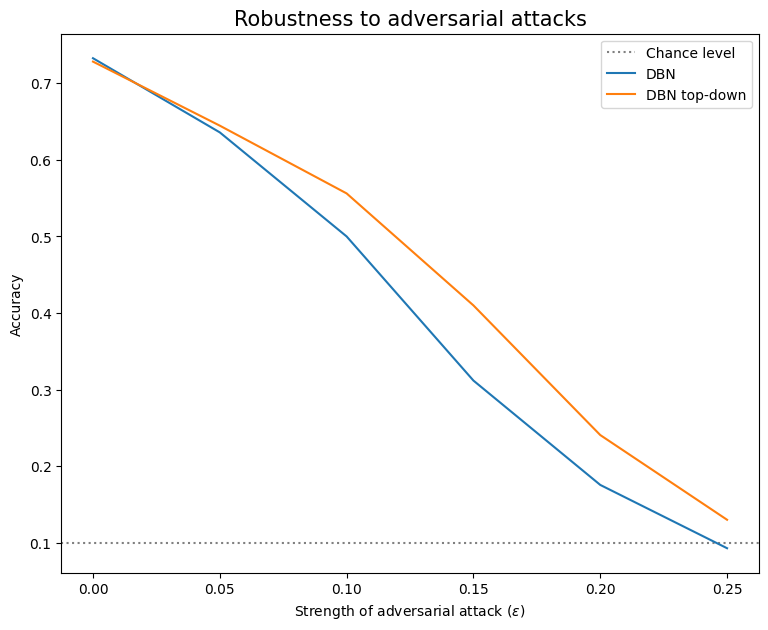

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(9, 7), sharey=True)

__ = ax.axhline(0.1, color='gray', linestyle=':')
__ = ax.plot(epsilon_values, accuracies_dbn_0)
__ = ax.plot(epsilon_values, accuracies_dbn_1)
__ = ax.set_xlabel("Strength of adversarial attack ($\epsilon$)")
__ = ax.set_ylabel("Accuracy")
__ = ax.set_title("Robustness to adversarial attacks", {'fontsize': 15})
__ = ax.legend(["Chance level","DBN", "DBN top-down"])

From the above plot we can see that by classifying the adversarially attacked sample on its DBN reconstruction instead of the original attacked sample, it becomes slighlty more robust to an adversarial attack.